<a href="https://colab.research.google.com/github/hrootscraft/customer-segmentation/blob/main/_2_KMeans_Clustering_BankCustomerSegmentationForMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aim

Demonstrate Clustering in the context of customer segmentation with the intent of marketing.
<br>

**Approaches** :
<br>
1.KMeans <br>
2.KPrototype <br>
3.Sentence Embedding with Kmeans

We'll also employ dimensionality reduction techniques, for inferring results, such as:

1.PCA <br>
2.t-SNE

## Setup Dependencies

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prakharrathi25/banking-dataset-marketing-targets

In [ ]:
!unzip banking-dataset-marketing-targets.zip

In [ ]:
!pip3 install pyod

## Extracting Useful Data and Processing it for Modeling

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv",sep=";")
df.sample(10)

age          job  marital  education default  balance housing loan  \
29591   32   technician   single  secondary      no        0      no   no   
19952   31   technician   single  secondary      no      942      no   no   
27640   47  blue-collar  married    primary      no     3451      no  yes   
12362   27   technician  married  secondary      no      594     yes   no   
32265   20  blue-collar   single  secondary      no      423     yes   no   
24404   56   management  married   tertiary      no     2551     yes   no   
14973   59   management  married   tertiary      no      220     yes   no   
36634   30       admin.  married  secondary      no      265     yes   no   
26105   30   technician   single  secondary      no     1416      no   no   
22940   37   technician  married  secondary      no     1578      no  yes   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
29591   cellular    3   feb       446         1     -1         0  unknown   no  
19952   cellular    8   aug       138         2     -1         0  unknown   no  
27640   cellular   21   nov       125         2     -1         0  unknown   no  
12362    unknown   27   jun       433         4     -1         0  unknown   no  
32265   cellular   16   apr       498         1     -1         0  unknown  yes  
24404   cellular   17   nov       150         2     -1         0  unknown   no  
14973  telephone   16   jul        30         2     -1         0  unknown   no  
36634   cellular   12   may       342         1    354         2  failure   no  
26105  telephone   19   nov       519         2     -1         0  unknown   no  
22940   cellular   26   aug        85         6     -1         0  unknown   no

We're gonna use the data related to the customer :

1. **age** (numeric)
2. **job** : type of job (categorical: *admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services*)
3. **marital** : marital status (categorical: *married, divorced, single*)
Note: *divorced* means divorced or widowed.
4. **education** (categorical: *unknown, secondary, primary, tertiary*)
5. **default**: has credit in default? (binary: *yes, no*)
6. **balance**: average yearly balance in euros (numeric)
7. **housing**: has housing loan? (binary: *yes,no*)
8. **loan**: has personal loan? (binary: *yes, no*)

In [6]:
required_df = df.iloc[:,0:8]

cat_cols = required_df.select_dtypes(include=['object']).columns
num_cols = required_df.select_dtypes(include=['int64']).columns

print("categorical columns",cat_cols)
print("numerical columns",num_cols)

categorical columns Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')
numerical columns Index(['age', 'balance'], dtype='object')


In [7]:
# preprocess:
# 1. encode catergorical data
# 2. make the numerical columns have a Gaussian Distribution
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
# Suppress FutureWarnings from sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)

ohe = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))])
ordinal_encode = Pipeline(steps=[("encoder", OrdinalEncoder())])
gauss_transform = Pipeline(steps=[("encoder", PowerTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_onehot', ohe, [value for value in cat_cols if value != 'education']),
        ('cat_ordinal', ordinal_encode, ["education"]),
        ('num_gauss', gauss_transform, num_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
transformed_data = pipeline.fit_transform(required_df) # numpy.ndarray

# Access the preprocessor from the pipeline and get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

new_df = pd.DataFrame(transformed_data, columns = feature_names.tolist())
print(new_df.columns.tolist())

['cat_onehot__job_blue-collar', 'cat_onehot__job_entrepreneur', 'cat_onehot__job_housemaid', 'cat_onehot__job_management', 'cat_onehot__job_retired', 'cat_onehot__job_self-employed', 'cat_onehot__job_services', 'cat_onehot__job_student', 'cat_onehot__job_technician', 'cat_onehot__job_unemployed', 'cat_onehot__job_unknown', 'cat_onehot__marital_married', 'cat_onehot__marital_single', 'cat_onehot__default_yes', 'cat_onehot__housing_yes', 'cat_onehot__loan_yes', 'cat_ordinal__education', 'num_gauss__age', 'num_gauss__balance']


In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cat_onehot__job_blue-collar    45211 non-null  float64
 1   cat_onehot__job_entrepreneur   45211 non-null  float64
 2   cat_onehot__job_housemaid      45211 non-null  float64
 3   cat_onehot__job_management     45211 non-null  float64
 4   cat_onehot__job_retired        45211 non-null  float64
 5   cat_onehot__job_self-employed  45211 non-null  float64
 6   cat_onehot__job_services       45211 non-null  float64
 7   cat_onehot__job_student        45211 non-null  float64
 8   cat_onehot__job_technician     45211 non-null  float64
 9   cat_onehot__job_unemployed     45211 non-null  float64
 10  cat_onehot__job_unknown        45211 non-null  float64
 11  cat_onehot__marital_married    45211 non-null  float64
 12  cat_onehot__marital_single     45211 non-null 

In [9]:
# update
num_cols = ['num_gauss__age','num_gauss__balance']

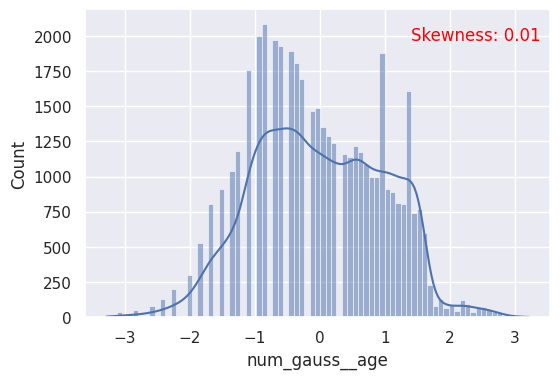

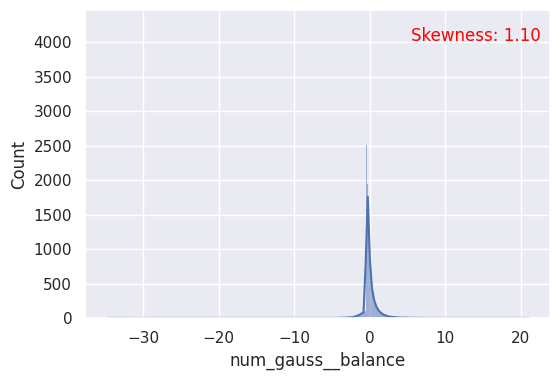

In [10]:
# check the work of yeo-johnson transform
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from scipy.stats import skew

for col in num_cols:
  plt.figure(figsize=(6, 4))
  ax = sns.histplot(data=new_df, x=col, kde=True)
  skewness = skew(new_df[col])
  ax.annotate(f'Skewness: {skewness:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12, color='red')
  plt.show()

The skewness has been significantly brought closer to 1 indicating a near to normal distribution. But, we still have to handle outliers, for which we'll use Python Outlier Detection (PyOD) library. This library is focused on detecting outliers for different cases. To be more specific, we'll use the ECOD method (“empirical cumulative distribution functions for outlier detection”). This method seeks to obtain the distribution of the data and thus know which are the values ​​where the probability density is lower (outliers).

In [11]:
# handle outliers
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(new_df)
outliers = clf.predict(new_df)

new_df["outliers"] = outliers
new_df.outliers

0        0
1        0
2        0
3        0
4        1
        ..
45206    0
45207    1
45208    1
45209    0
45210    0
Name: outliers, Length: 45211, dtype: int64

In [12]:
# we do this because later on we use this original data without outliers as input to
# the classifier used for evaluation of clustering algorithm which in turn gets us SHAP values
required_df["outliers"] = outliers
required_df_wo_outliers = required_df[required_df.outliers==0]
required_df_wo_outliers = required_df_wo_outliers.drop(["outliers"], axis=1)

In [13]:
## data without outliers
new_df_wo_outliers = new_df[new_df["outliers"] == 0]
new_df_wo_outliers = new_df_wo_outliers.drop(["outliers"], axis = 1)

## data with outliers
new_df_w_outliers = new_df.copy()
new_df_w_outliers = new_df_w_outliers.drop(["outliers"], axis = 1)

print(new_df_wo_outliers.shape) # -> (40690, 19)
print(new_df_w_outliers.shape) # -> (45211, 19)

(40690, 19)
(45211, 19)


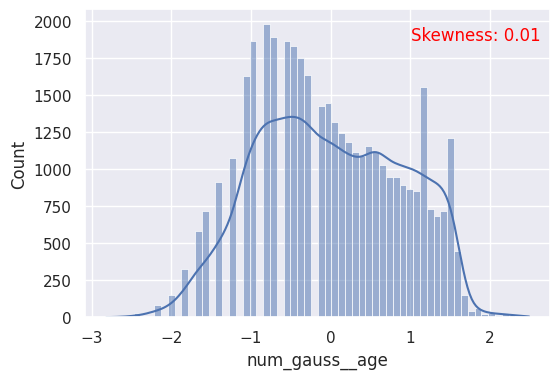

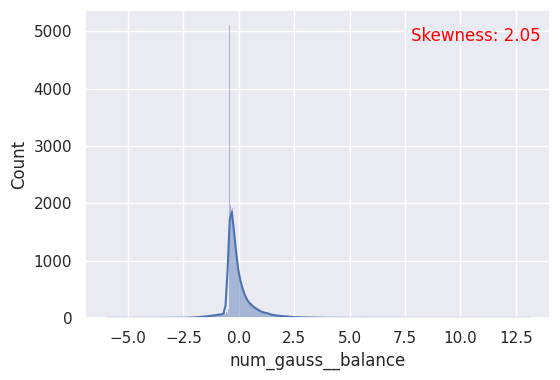

In [14]:
# skewness in age is reduced, and the shrink in x-axis proves outliers have been removed even though it increased the skewness a bit
sns.set_theme()

for col in num_cols:
  plt.figure(figsize=(6, 4))
  ax = sns.histplot(data=new_df_wo_outliers, x=col, kde=True)
  skewness = skew(new_df_wo_outliers[col])
  ax.annotate(f'Skewness: {skewness:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12, color='red')
  plt.show()

## 1. K-Means

In [15]:
# Select k using the Elbow Method
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")

# ‘k-means++’ : selects initial cluster centroids using sampling based on an
# empirical probability distribution of the points’ contribution
# to the overall inertia. This technique speeds up convergence

# n_init: number of times the k-means algorithm is run with different centroid seeds
# 1 if using init='k-means++' or init is an array-like.

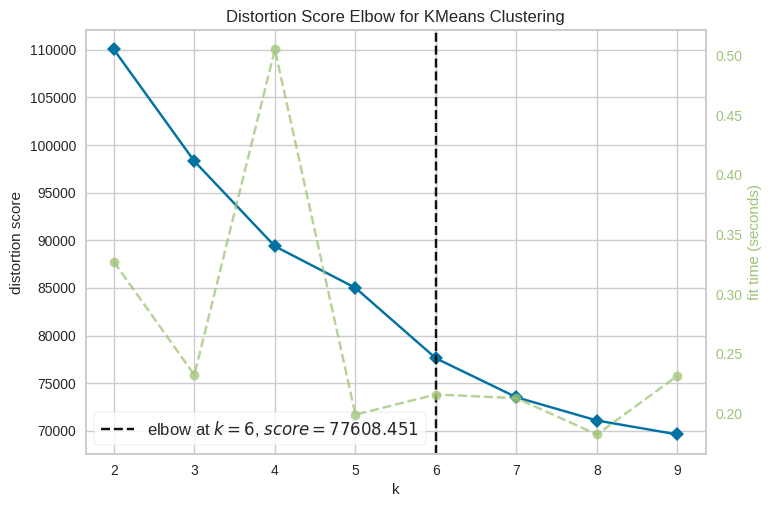

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
visualizer = KElbowVisualizer(km, k=(2,10))
visualizer.fit(new_df_wo_outliers) # Fit the data to the visualizer
visualizer.show()

To validate, let's use silhouette score too:

We select the k for which silhoutte score is maximized and most clusters have their edges beyond the mean line in the plots meaning they are classified properly in their clusters.

Also, these clusters must have their widths more or less the same.

refer this vid : https://youtu.be/u1EUrxobvk8?si=BDZFEq_0kUh1AOZv from 7.51 timestamp

In [17]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

def silhouette_plot(X, n_clusters):
    # set the plot limits
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, n_init=10, init='k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label each cluster in the silhouette plot
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Update y_lower for the next plot
        y_lower = y_upper + 10

        plt.title(f"Silhouette Plot for n_cluster = {n_clusters}")
        plt.xlabel("Silhouette coefficient values")
        plt.ylabel("Cluster Label")

        # Add a vertical line at the average silhouette score
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        # Remove y-axis labels
        plt.yticks([])
        # Set x-axis ticks
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

For n_clusters = 2, the average silhouette_score is: 0.1811203857008704


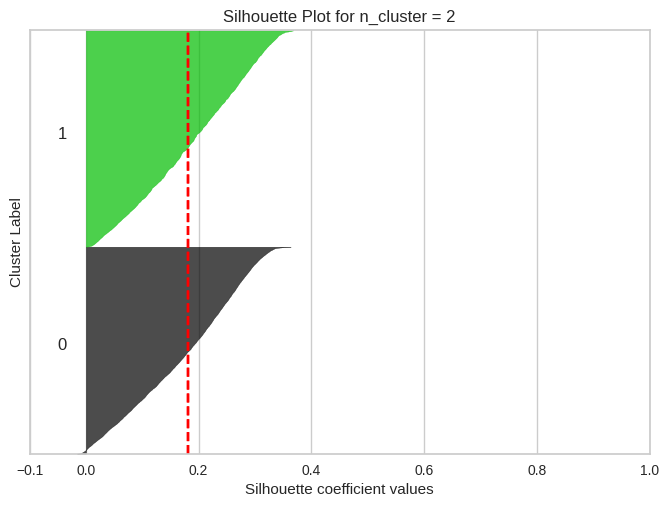

For n_clusters = 3, the average silhouette_score is: 0.1678772365672131


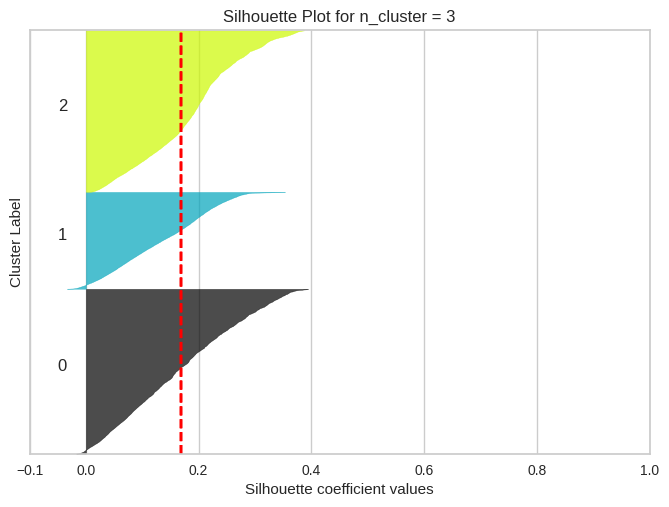

For n_clusters = 4, the average silhouette_score is: 0.1583339516592204


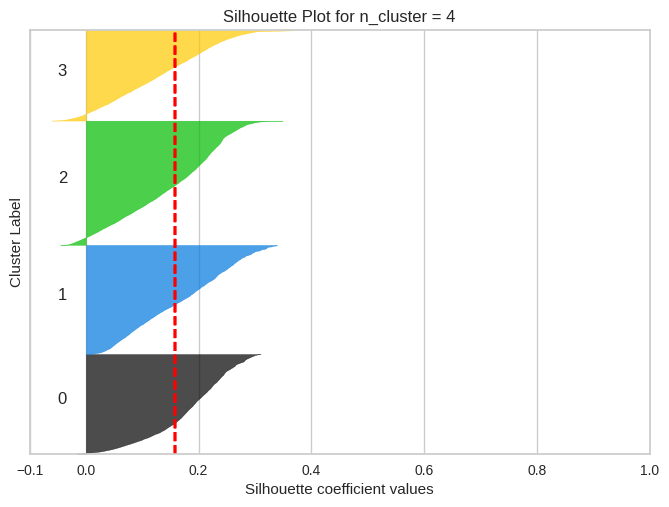

For n_clusters = 5, the average silhouette_score is: 0.16728150772467024


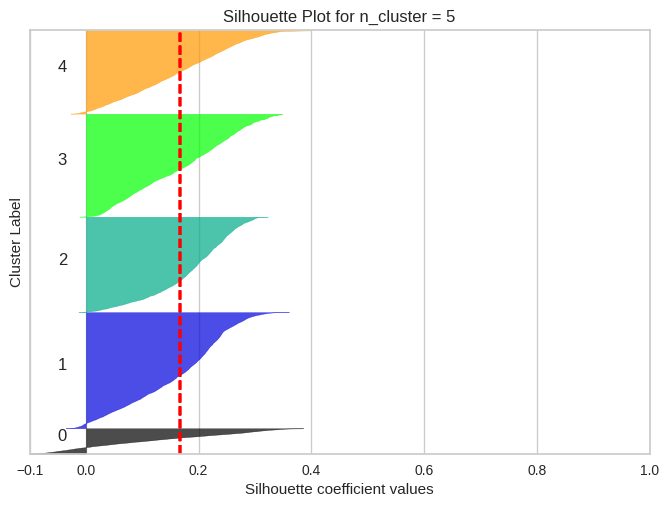

For n_clusters = 6, the average silhouette_score is: 0.15673800169997673


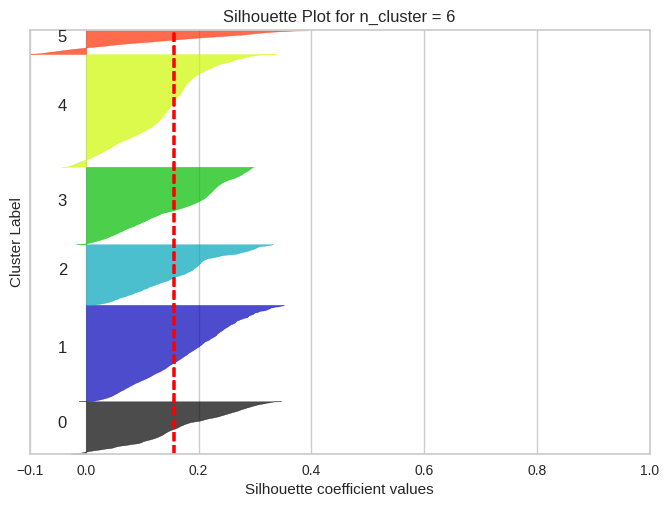

For n_clusters = 7, the average silhouette_score is: 0.14952635264854028


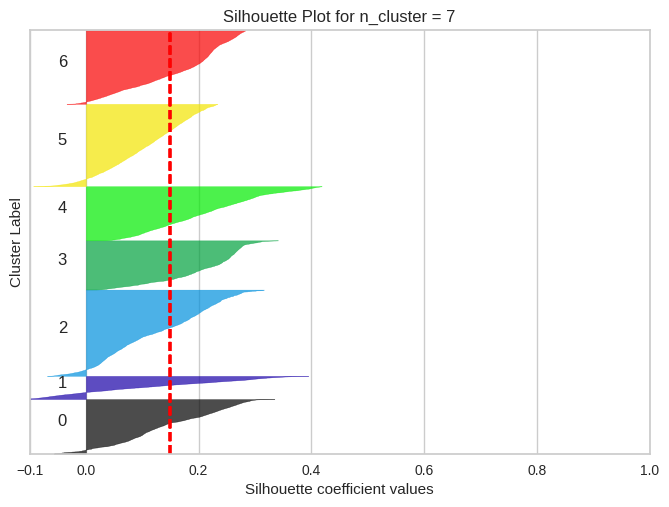

For n_clusters = 8, the average silhouette_score is: 0.15241441965401636


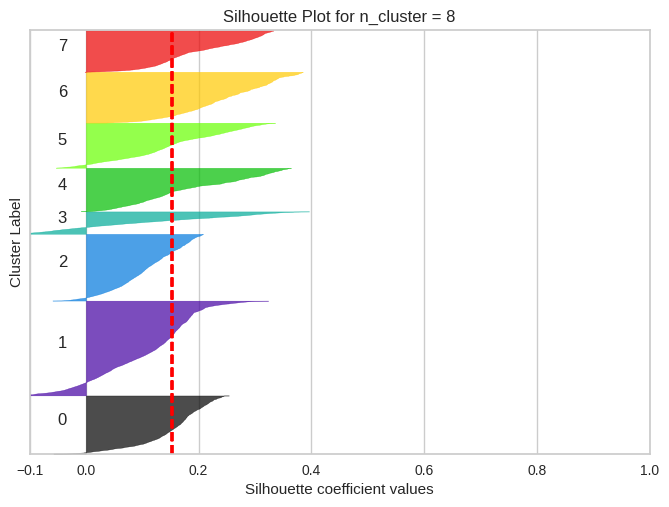

For n_clusters = 9, the average silhouette_score is: 0.14650206459561266


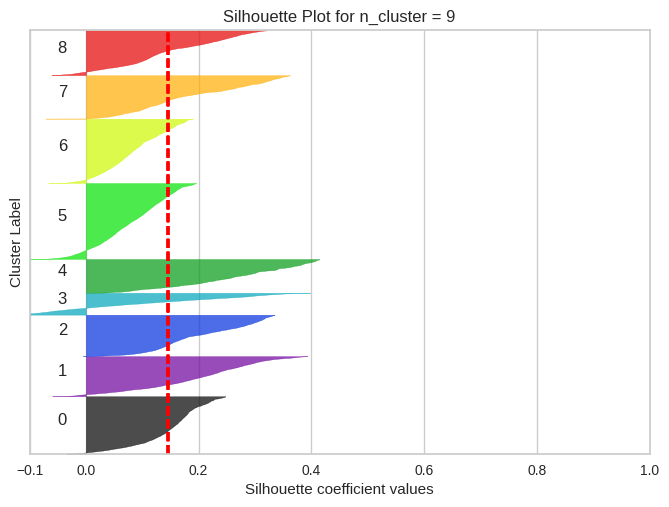

In [18]:
# Loop through each value of k and create a silhouette plot
for n_clusters in range(2,10):
    silhouette_plot(new_df_wo_outliers, n_clusters)
    # plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.show()
    # Close the plot to avoid overlapping when saving multiple plots
    # plt.close()

In [19]:
# For n_clusters = 9, the average silhouette_score is: 0.14650206459561266
# For n_clusters = 8, the average silhouette_score is: 0.15241441965401636
# For n_clusters = 7, the average silhouette_score is: 0.14952635264854028
# For n_clusters = 6, the average silhouette_score is: 0.15673800169997673
# For n_clusters = 5, the average silhouette_score is: 0.16728150772467024
# For n_clusters = 4, the average silhouette_score is: 0.1583339516592204
# For n_clusters = 3, the average silhouette_score is: 0.1678772365672131
# For n_clusters = 2, the average silhouette_score is: 0.1811203857008704

Inference:

The maximum silhouette score is obtained for k=5 after taking into account a considerable # of clusters. Also, it seems misclassifications are comparatively lower and there is no imbalance in cluster size.

In [20]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42)
predicted_cluster_labels = km.fit_predict(new_df_wo_outliers)
predicted_cluster_labels

array([0, 4, 2, ..., 0, 1, 2], dtype=int32)

In [21]:
np.unique(predicted_cluster_labels)

array([0, 1, 2, 3, 4], dtype=int32)

## Evaluation

Assessing the performance of KMeans models is characterized by a more versatile approach compared to other models. We can use metrics like davies_bouldin_score, calinski_harabasz_score, silhouette_score and visualizations leading to interpretation.

### Metrics

In [22]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

"""
The Davies Bouldin index is defined as the average similarity measure
of each cluster with its most similar cluster, where similarity
is the ratio of within-cluster distances to between-cluster distances.
It assesses the compactness and separation of clusters. It is based on the idea that
good clusters should have minimal intra-cluster distance and maximal inter-cluster distance.

Range:
    Minimum Value: The Davies-Bouldin Index has a minimum value of 0,
    which occurs when clusters are perfectly separated with no overlap.

    Maximum Value: There is no specific upper bound for the Davies-Bouldin Index.
    However, it tends to increase with worse clustering solutions.
    The closer the index is to 0, the better the clustering solution.
"""
print(f"Davies bouldin score: {davies_bouldin_score(new_df_wo_outliers,predicted_cluster_labels)}")


"""
The Calinski-Harabasz Index, also known as the Variance Ratio Criterion,
is a measure used to evaluate the goodness of a clustering technique.
It is calculated as the ratio of the between-cluster variance to the
within-cluster variance. The index is higher when clusters are dense
and well separated. A higher Calinski-Harabasz Index indicates a better clustering result.

The formula for the Calinski-Harabasz Index is given by:
CH = B(k)/W(k) × (N−k)/(k−1)
Where:
    CH is the Calinski-Harabasz Index.
    B(k) is the between-cluster variance.
    W(k) is the within-cluster variance.
    N is the total number of data points.
    k is the number of clusters.

Interpretation:
    Higher Values: A higher Calinski-Harabasz Index suggests better-defined clusters.
    When comparing different clustering solutions, the one with a higher CH index is considered better.

    Optimal Number of Clusters: Researchers often use the Calinski-Harabasz Index to
    determine the optimal number of clusters for a dataset. The number of clusters
    that maximizes the index is considered the optimal choice.

    Consideration of Other Metrics: While the Calinski-Harabasz Index is a useful metric,
    it's often recommended to consider it in conjunction with other clustering
    evaluation metrics, as no single metric is perfect for all types of data.

Range:
    Minimum Value: Theoretically, the minimum value of the Calinski-Harabasz Index is 0.
    This would happen if the between-cluster variance is zero, meaning there is no separation between clusters.

    Maximum Value: There is no upper bound for the Calinski-Harabasz Index.
    Higher values are generally better, indicating well-separated and dense clusters.
    The maximum value is influenced by the number of clusters and the characteristics of the data.
"""
print(f"Calinski Score: {calinski_harabasz_score(new_df_wo_outliers,predicted_cluster_labels)}")


"""
The silhouette score is a metric used to calculate the goodness of
fit of a clustering algorithm, but can also be used as
a method for determining an optimal value of k.

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(new_df_wo_outliers, predicted_cluster_labels)}")

Davies bouldin score: 1.6775659296391374
Calinski Score: 6914.724747148269
Silhouette Score: 0.1672869940907191


By Davies’ bouldin score, we know that is high meaning the distance between clusters is quite small.

This may be due to several factors, but keep in mind that the model works as per the quality of data; if the data does not have sufficient predictive power, you cannot expect to achieve exceptional results.

### Visualizations

#### 1.PCA

In [23]:
!pip3 install prince

In [24]:
import prince

# The available parameters are:

#     n_components — the number of components that are computed. You only need two if your intention is to visualize the two major components.
#     n_iter — the number of iterations used for computing the SVD.

# SVD is an iterative process that decomposes a data matrix into three other matrices,
# capturing the underlying structure of the data. The n_iter parameter determines
# how many iterations the SVD algorithm should perform to converge to a solution.
# More iterations generally lead to a more accurate result but may also increase computational time.

#     rescale_with_mean — whether to substract each column’s mean
#     rescale_with_std — whether to divide each column by it’s standard deviation
#     copy — if False then the computations will be done inplace which can have possible side-effects on the input data
#     engine — what SVD engine to use (should be one of ['fbpca', 'sklearn'])
#     random_state — controls the randomness of the SVD results.

def get_pca_2d(df, predicted_labels):
    pca_2d_obj = prince.PCA(
      n_components=2,
      n_iter=3,
      rescale_with_mean=True,
      rescale_with_std=True,
      copy=True,
      check_input=True,
      engine='sklearn',
      random_state=42
    )
    pca_2d_obj.fit(df)
    df_pca_2d = pca_2d_obj.transform(df)
    df_pca_2d.columns = ["PC1", "PC2"]
    df_pca_2d["cluster"] = predicted_labels
    return pca_2d_obj, df_pca_2d

In [25]:
import plotly.express as px

def plot_pca_2d(df, opacity=0.8, width_line = 0.1):
    # convert the datatype of cluster labels to object so as to get considered as a categorical column
    df = df.astype({"cluster": "object"})
    # df = df.sort_values("cluster")
    fig = px.scatter(df, x="PC1", y="PC2", color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 8, "opacity": opacity,"line":{"width": width_line, "color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True, showlegend = True,scene = dict(xaxis=dict(title = 'PC1'), yaxis=dict(title = 'PC2')))
    fig.show()

In [26]:
pca_2d_object, df_pca_2d = get_pca_2d(new_df_wo_outliers, predicted_cluster_labels)
print(df_pca_2d)

            PC1       PC2  cluster
0     -0.421579  2.327138        0
1      1.593367 -1.049572        4
2     -0.949384 -0.257493        2
3     -0.776843  0.497439        0
5      0.377897  1.468730        0
...         ...       ...      ...
45202  1.776742 -0.631230        4
45205  2.418956 -1.300275        4
45206 -0.428591  1.434998        0
45209 -1.960180 -0.025490        1
45210 -0.888322  1.010667        2

[40690 rows x 3 columns]


In [27]:
plot_pca_2d(df_pca_2d, opacity=1, width_line = 0.5)

In [28]:
pca_2d_object.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.245        11.81%                     11.81%
1              1.772         9.33%                     21.14%

In [29]:
pca_2d_object.scree_plot()

alt.Chart(...)

In our dataset with no outliers, the first 2 components explain ~21% of the dataset inertia. This isn’t great. Neither can we see any seperation between the clusters which is in accordance with our evaluation metrics. Let's calculate the 3rd PCA component too to see how much the cumulative variability increases.

In [30]:
# High absolute values of column correlations for a specific principal component suggest
# that the corresponding original features strongly contribute to that principal component.
# Low or close-to-zero correlations suggest that the original features
# have little influence on that particular principal component.
column_correlations = pca_2d_object.column_correlations
print(column_correlations)

component                             0         1
variable                                         
cat_onehot__job_blue-collar   -0.375675 -0.557187
cat_onehot__job_entrepreneur  -0.058490  0.083213
cat_onehot__job_housemaid     -0.129847  0.005840
cat_onehot__job_management     0.340882  0.639422
cat_onehot__job_retired       -0.249576  0.199198
cat_onehot__job_self-employed  0.005847  0.066551
cat_onehot__job_services      -0.006744 -0.195952
cat_onehot__job_student        0.154739 -0.112926
cat_onehot__job_technician     0.170048 -0.033026
cat_onehot__job_unemployed    -0.017200  0.036645
cat_onehot__job_unknown       -0.031306  0.022437
cat_onehot__marital_married   -0.777098  0.260465
cat_onehot__marital_single     0.820742 -0.303790
cat_onehot__default_yes       -0.031163 -0.012589
cat_onehot__housing_yes       -0.037992 -0.409557
cat_onehot__loan_yes          -0.097201 -0.081104
cat_ordinal__education         0.492107  0.613432
num_gauss__age                -0.564417  0.403764


Features with higher absolute correlation values (close to 1 or -1) for a specific principal component are more important in determining the patterns captured by that component.

It seems marital status highly contributes to patterns detected by PC1 followed by age. And education is that third feature that contributes majorly to patterns captured by PC2. These 3 features might be the differentiating features of the clusters. To find out feature importance in KMeans model let's use a trick later on where we build a classification model and the inputs 'X' to it will be the features we fed to the KMeans model itself but the target 'y' will be the cluster labels. Using SHAP values, we can find out

In [31]:
def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )
    pca_3d_object.fit(df)
    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["PC1", "PC2", "PC3"]
    df_pca_3d["cluster"] = predict
    return pca_3d_object, df_pca_3d

In [32]:
def plot_pca_3d(df, opacity=0.8, width_line = 0.1):
    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 4, "opacity": opacity, "line": {"width": width_line,"color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True,
                   showlegend = True, scene = dict(xaxis=dict(title = 'PC1'),
                                                   yaxis=dict(title = 'PC2'),
                                                   zaxis=dict(title = 'PC3')))
    fig.show()

In [33]:
pca_3d_object, df_pca_3d = get_pca_3d(new_df_wo_outliers, predicted_cluster_labels)
plot_pca_3d(df_pca_3d, opacity=1, width_line = 0.1)

It can be concluded that the clusters lack clear separation and exhibit minimal distinction between them. This observation also aligns with the insights derived from the evaluation metrics.

In [34]:
pca_3d_object.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.244        11.81%                     11.81%
1              1.772         9.33%                     21.14%
2              1.243         6.54%                     27.68%

In [35]:
# pca_3d_object.scree_plot()

If the accumulated sum of the 3 main components adds up to around 80% variability, we can say that it is acceptable, obtaining good results in the representations. If the value is lower, like in this case ~28%, we have to take the visualizations with a grain of salt since we are missing a lot of information that is contained in other eigenvectors.
<br>
<br>

*Side Note: Why understanding this variability can be important?*

*One of the primary purposes of PCA is to reduce the dimensionality of a dataset while retaining as much of the original variability as possible. By expressing the data in terms of principal components, which are linear combinations of the original variables, we can represent the data in a lower-dimensional space. If the first few principal components capture a significant portion of the variance, we can potentially represent the data using fewer features without losing much information.*

*The amount of variance explained by each principal component can give insights into which features contribute the most to the overall variability in the dataset. Features with higher contributions to variance are considered more important in terms of explaining the structure of the data.*


#### 2.t-SNE

Since PCA is a linear algorithm, it is not capable of capturing more complex relationships. But t-SNE is capable of capturing these complex polynomial relationships.

K-Means can perform well when the underlying structure of the data is well-suited to clustering and when clusters are roughly spherical and equally sized. However, it may struggle with non-uniformly sized or shaped clusters. The choice of the initial cluster centers can also impact performance, and the algorithm may converge to local optima.

In [36]:
from sklearn.manifold import TSNE

sampling_data = new_df_wo_outliers.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(predicted_cluster_labels).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(n_components=3, learning_rate=700, init='random', perplexity=100, n_iter = 1000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["PC1", "PC2",'PC3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, opacity=1, width_line = 0.1)

In [37]:
df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["PC1", "PC2"])
df_tsne_2d["cluster"] = sampling_clusters
plot_pca_2d(df_tsne_2d, opacity=1, width_line = 0.5)

We can observe clearer separation between clusters but these are still not the best results.

### Evaluation by Classification

In [38]:
!pip3 install shap

Here, we'll use the trick we talked about earlier when we got the column correlations with Principal Components.

By visualizing the SHAP values, you can identify which features contribute the most to the clustering decisions made by the K-means model.

Introductory information on SHAP values: https://youtu.be/L8_sVRhBDLU?si=N9QBvuPqwy6wD7xa
<br><br>
categorical columns ['job', 'marital', 'education', 'default', 'housing', 'loan']

numerical columns ['age', 'balance']

In [39]:
required_df_wo_outliers.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan'],
      dtype='object')

In [40]:
import lightgbm as lgb

for col in cat_cols:
    required_df_wo_outliers[col] = required_df_wo_outliers[col].astype('category')

In [41]:
lgbm_clf_for_km = lgb.LGBMClassifier(colsample_bytree=0.8)
lgbm_clf_for_km.fit(X=required_df_wo_outliers,
                    y=predicted_cluster_labels,
                    feature_name="auto",
                    categorical_feature="auto")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 8
[LightGBM] [Info] Start training from score -1.626166
[LightGBM] [Info] Start training from score -1.292930
[LightGBM] [Info] Start training from score -1.412943
[LightGBM] [Info] Start training from score -2.815215
[LightGBM] [Info] Start training from score -1.489282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.8)

In [42]:
# from sklearn.metrics import accuracy_score, classification_report

# y_pred = lgbm_clf_for_km.predict(required_df_wo_outliers)
# accuracy=accuracy_score(y_pred, predicted_cluster_labels)
# print('Training-set accuracy score: {0:0.4f}'.format(accuracy))
# print(classification_report(predicted_cluster_labels, y_pred))

In [43]:
from sklearn.model_selection import cross_val_score

# scoring metric is f1 weighted because among the 5 clusters our KMeans model found one of them
# was thin in size ergo safer side we take weighted f1 score to account for imbalanced classes
cv_scores_lgbm_clf_for_km = cross_val_score(lgbm_clf_for_km, required_df_wo_outliers, predicted_cluster_labels, scoring='f1_weighted')
print(f'CV F1 score for KMeans clusters is {np.mean(cv_scores_lgbm_clf_for_km)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 32552, number of used features: 8
[LightGBM] [Info] Start training from score -1.626228
[LightGBM] [Info] Start training from score -1.292975
[LightGBM] [Info] Start training from score -1.412943
[LightGBM] [Info] Start training from score -2.815009
[LightGBM] [Info] Start training from score -1.489228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 32552, number of used features: 8
[Light

CV score for KMeans is 0.99 which means that the customers are grouped in meaningful and distinguishable clusters. Now, let’s see the feature importances to determine if the classifier has used all the information available to it.

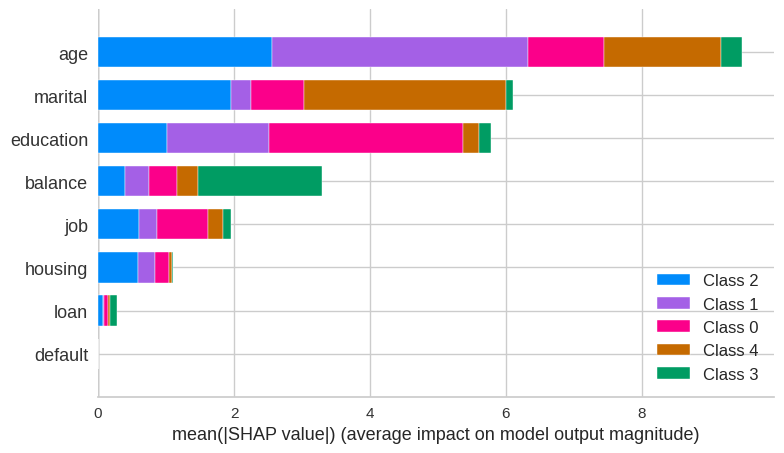

In [44]:
import shap
km_explainer = shap.TreeExplainer(lgbm_clf_for_km)
km_shap_values = km_explainer.shap_values(required_df_wo_outliers)
shap.summary_plot(km_shap_values, required_df_wo_outliers, plot_type="bar")

- Age has the greatest predictive power when clustering with KMeans.
- Cluster 3 (green) is mainly differentiated by the balance variable.

## Cluster Information

For each cluster we find the mean value for the numerical features and the most frequent value for categorical features.

In [45]:
required_df_wo_outliers["cluster"] = predicted_cluster_labels

cluster_summary = required_df_wo_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
    }
)

cluster_summary.sort_values("age").reset_index()

cluster          job  marital  education housing loan        age  \
0        4   technician   single  secondary     yes   no  32.069740   
1        2  blue-collar  married  secondary     yes   no  34.569409   
2        3   management  married  secondary     yes   no  42.183012   
3        0   management  married   tertiary      no   no  43.773960   
4        1  blue-collar  married  secondary      no   no  50.220989   

       balance default  
0   794.696306      no  
1   592.025644      no  
2  7526.310217      no  
3   872.797951      no  
4   836.407504      no

- Clusters with job=blue-collar do not have distinct differences between their characteristics, except the age feature. This is not desirable since it is difficult to differentiate the clients in each cluster.
- In the job=management case, we obtain better differentiation wrt education and balance.

Post these results, we might want to try some other models suited for Clustering.

Let's try KPrototype because in it we won't have to modify our categorical variables like we did in KMeans. KMeans does not support categorical variables as is and we OHE them which forces the original dataset to be altered drastically.